In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [7]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [8]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [212]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [213]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [214]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [215]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [216]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.30 errD_z: 0.11 errG: 2.31
Epoch:1 Iter: 200 errD_x: 0.37 errD_z: 0.12 errG: 2.57
Epoch:1 Iter: 300 errD_x: 0.22 errD_z: 0.16 errG: 2.30
Epoch:1 Iter: 400 errD_x: 0.26 errD_z: 0.09 errG: 2.60
Epoch:1 Iter: 500 errD_x: 0.04 errD_z: 0.11 errG: 2.45
Epoch:1 Iter: 600 errD_x: 0.27 errD_z: 0.09 errG: 2.53
Epoch:1 Iter: 700 errD_x: 0.19 errD_z: 0.04 errG: 3.29
Epoch:1 Iter: 800 errD_x: 0.16 errD_z: 0.09 errG: 2.50
Epoch:1 Iter: 900 errD_x: 0.01 errD_z: 0.27 errG: 1.76
Epoch:1 Iter: 1000 errD_x: 0.06 errD_z: 0.09 errG: 2.65
Epoch:1 Iter: 1100 errD_x: 0.07 errD_z: 0.24 errG: 1.86
Epoch:1 Iter: 1200 errD_x: 0.09 errD_z: 0.10 errG: 2.58
Epoch:1 Iter: 1300 errD_x: 0.04 errD_z: 0.27 errG: 1.81
Epoch:1 Iter: 1400 errD_x: 0.11 errD_z: 0.15 errG: 2.39
Epoch:1 Iter: 1500 errD_x: 0.06 errD_z: 0.20 errG: 2.08
Epoch:1 Iter: 1600 errD_x: 0.14 errD_z: 0.13 errG: 2.47
Epoch:1 Iter: 1700 errD_x: 0.11 errD_z: 0.15 errG: 2.41
Epoch:1 Iter: 1800 errD_x: 0.18 errD_z: 0.24 errG: 1.92
E

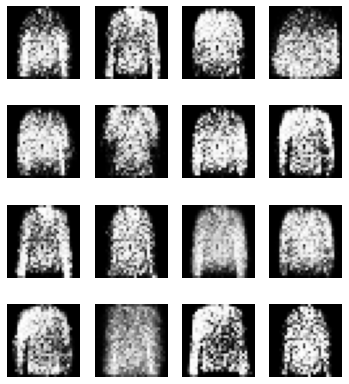

In [17]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

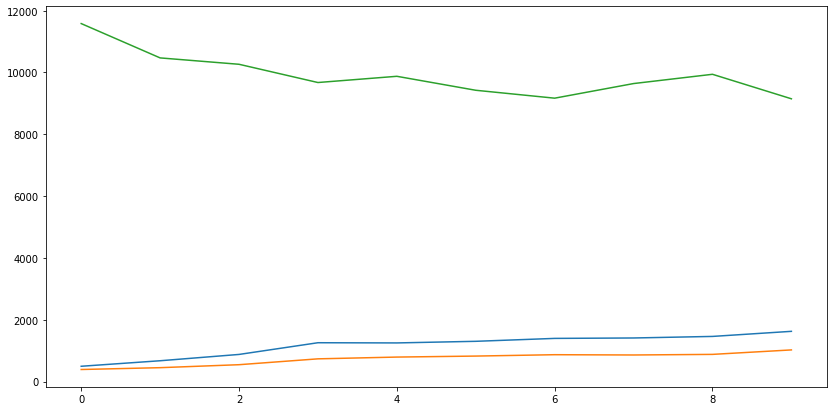

In [217]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(ERRD_x, label='errD_x')
plt.plot(ERRD_z, label='errD_z')
plt.plot(ERRG, label='errG')

### Интерполяция

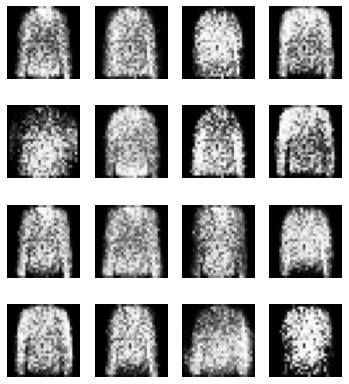

In [42]:
plt.figure(figsize=(6, 7))

with torch.no_grad():

    while True:
        noise.data.normal_(0, 1)
        noise_v1 = noise.clone()
        noise.data.normal_(0, 1)
        noise_v2 = noise.clone()
        eps = 1e-6
        norm = torch.norm( noise_v2 - noise_v1, p=2)
        if norm > eps:
            break


    v0 = noise_v1
    r = (noise_v2 - noise_v1) / norm
    fakes = []

    for t in np.linspace(0, norm, 100):
        noise_v = v0 + t * r
        fake = generator(noise_v)
        fakes.append( fake.detach().numpy().reshape(16, 28, 28) )

    result = np.mean(fakes, axis=0)

    for i in range(16):

        plt.subplot(4, 4, i + 1)
        plt.imshow(result[i], cmap=plt.cm.Greys_r)
        plt.axis('off')


Sampling points from segment:


l^ = a^ + t * r^

a^ = p1

r^ = (p2 - p1) / || p2 - p1 ||

t in [0; ||p2 - p1|| ]




### LSGAN

In [1]:
x = torch.cat([x2, x1], dim=1)

NameError: ignored

In [9]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 1024
config.print_freq = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.linear_part = nn.Sequential( 
            nn.Linear(config.noise_size, 7 * 7 * 128),
            nn.BatchNorm1D(7 * 7 * 128),
            nn.ReLU(inplace=True),
        )
        shape_2d = (-1, 7, 7, 128)

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=5, stride=2), 
            nn.BatchNorm2D(128),
            nn.ReLU(inplace=True),
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=5, stride=2), 
        )
        
    def forward(self, x):

        z = self.linear_part(x)
        z = z.view(shape_2d)

        z = self.deconv1(z)
        z = self.deconv2(z)

        return z

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 1 28 28

        self.conv = nn.Sequential(

            nn.Conv2D(1, 256, kernel_size=5, stride=2), 
            nn.ReLU(),

            nn.Conv2D(256, 320, kernel_size=5, stride=2),
            nn.BatchNorm2D(320),
            nn.ReLU(),
        )

        self.linear = nn.Sequential(
            nn.Linear(320 * 20 * 20, 1024),
            nn.BatchNorm1D(1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 1), 
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        z = self.conv(x)
        z = z.view(batch_size, -1)
        z = self.linear(z)
        return z
        

In [140]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential( 
            nn.ConvTranspose2d(config.noise_size, 256, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 256, kernel_size=6, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            

            nn.ConvTranspose2d(256, 256 // 2, kernel_size=6, stride=2, padding=1),
            nn.BatchNorm2d(256 // 2),
            nn.ReLU(inplace=True),
            

            nn.ConvTranspose2d(256 // 2, 256 // 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256 // 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256 // 4, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        z = x.view(-1, config.noise_size, 1, 1)
        return self.model(z)

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 1 28 28

        self.conv = nn.Sequential(

            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2), 
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
        )

        self.linear = nn.Linear(512 * 2 * 2, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        z = self.conv(x)
        z = z.view(batch_size, -1)
        z = self.linear(z)
        return z

In [141]:
generator = Generator()
discriminator = Discriminator()

In [142]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [143]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

In [145]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(5):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images#.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = 0.5 * criterion( output, label )

        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)

        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = 0.5 * torch.square( output - label ).mean()

        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = 0.5 * criterion( output, label )
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 0.53
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 0.51
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.50
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 0.54
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 0.51
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.00 errG: 0.52
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 0.48
Epoch:1 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 0.51
Epoch:1 Iter: 900 errD_x: 0.00 errD_z: 0.00 errG: 0.56
Epoch:1 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 0.64
Epoch:1 Iter: 1100 errD_x: 0.05 errD_z: 0.02 errG: 0.50
Epoch:1 Iter: 1200 errD_x: 0.00 errD_z: 0.00 errG: 0.54
Epoch:1 Iter: 1300 errD_x: 0.00 errD_z: 0.00 errG: 0.63
Epoch:1 Iter: 1400 errD_x: 0.02 errD_z: 0.00 errG: 0.40
Epoch:1 Iter: 1500 errD_x: 0.00 errD_z: 0.00 errG: 0.50
Epoch:1 Iter: 1600 errD_x: 0.02 errD_z: 0.03 errG: 0.60
Epoch:1 Iter: 1700 errD_x: 0.02 errD_z: 0.01 errG: 0.63
Epoch:1 Iter: 1800 errD_x: 0.01 errD_z: 0.01 errG: 0.46
E

KeyboardInterrupt: ignored

1.5 эпохи за 1.5 часа

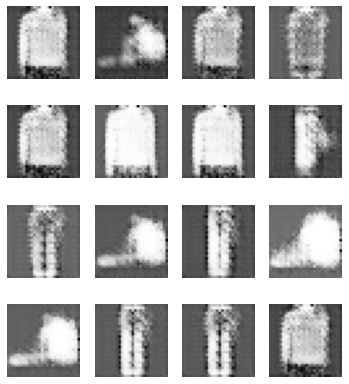

In [147]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [150]:
import copy
generator_t = copy.deepcopy(generator)
discriminator_t = copy.deepcopy(discriminator)

### Условная генерация

In [163]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 1024
config.print_freq = 100
config.emb_size = 256
config.num_classes = 10

In [185]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.embedding = nn.Linear(config.num_classes, config.emb_size)

        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + config.emb_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x, y):
        
        emb = self.embedding(y)
        z = torch.cat([x, emb], 1)
        return self.model(z)

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.embedding = nn.Linear(config.num_classes, config.emb_size)

        self.model = nn.Sequential(
            nn.Linear(28*28 + config.emb_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
        
    def forward(self, x, y):

        emb = self.embedding(y)
        im = torch.cat([x, emb], 1)

        return self.model(im)

In [186]:
generator = Generator()
discriminator = Discriminator()

In [187]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [188]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size, 1))
real_label = 1
fake_label = 0

In [190]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()

        one_hot_cat = Variable(torch.zeros(config.batch_size, config.num_classes))
        one_hot_cat[:, cat] = 1.0
        

        #one_hot_cat[cat] = 1

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, one_hot_cat)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise, one_hot_cat)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), one_hot_cat)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, one_hot_cat)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.51 errD_z: 0.50 errG: 1.04
Epoch:1 Iter: 200 errD_x: 0.63 errD_z: 0.53 errG: 0.98
Epoch:1 Iter: 300 errD_x: 0.36 errD_z: 0.27 errG: 1.57
Epoch:1 Iter: 400 errD_x: 0.36 errD_z: 0.34 errG: 1.35
Epoch:1 Iter: 500 errD_x: 0.22 errD_z: 0.22 errG: 1.79
Epoch:1 Iter: 600 errD_x: 0.07 errD_z: 0.12 errG: 2.44
Epoch:1 Iter: 700 errD_x: 0.27 errD_z: 0.33 errG: 1.49
Epoch:1 Iter: 800 errD_x: 0.11 errD_z: 0.12 errG: 2.42
Epoch:1 Iter: 900 errD_x: 0.06 errD_z: 0.07 errG: 2.91
Epoch:1 Iter: 1000 errD_x: 0.08 errD_z: 0.11 errG: 2.70
Epoch:1 Iter: 1100 errD_x: 0.29 errD_z: 0.28 errG: 1.61
Epoch:1 Iter: 1200 errD_x: 0.24 errD_z: 0.16 errG: 2.13
Epoch:1 Iter: 1300 errD_x: 0.58 errD_z: 0.39 errG: 1.33
Epoch:1 Iter: 1400 errD_x: 0.56 errD_z: 0.49 errG: 1.20
Epoch:1 Iter: 1500 errD_x: 0.26 errD_z: 0.22 errG: 1.74
Epoch:1 Iter: 1600 errD_x: 0.24 errD_z: 0.21 errG: 1.99
Epoch:1 Iter: 1700 errD_x: 0.14 errD_z: 0.21 errG: 1.94
Epoch:1 Iter: 1800 errD_x: 0.36 errD_z: 0.18 errG: 2.15
E

tensor([3, 7, 2, 7, 8, 1, 1, 3, 4, 4, 2, 5, 5, 2, 0, 5])

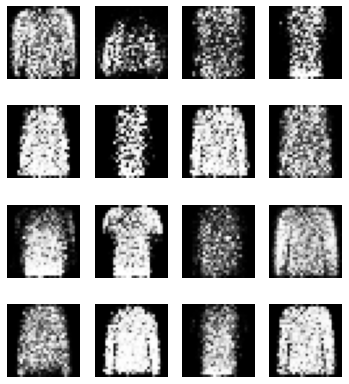

In [205]:
noise.data.normal_(0, 1)
one_hot_cat = torch.zeros(config.batch_size, config.num_classes )
one_hot_cat[ torch.randint(0, 9, (config.batch_size,) ) ] = 1.0

fake = generator(noise, one_hot_cat)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

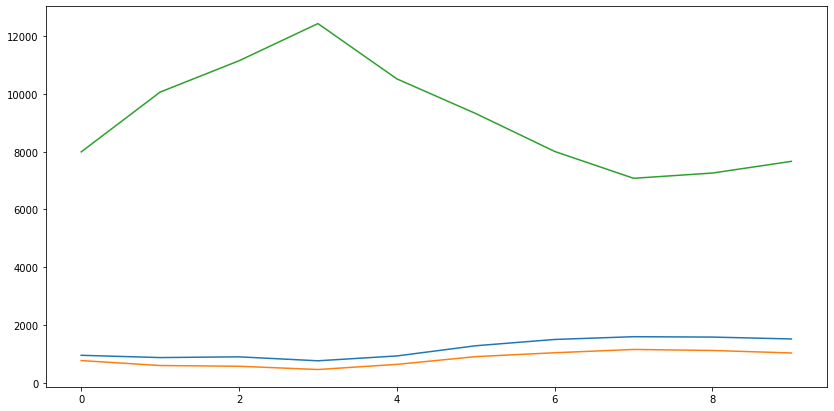

In [211]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(ERRD_x, label='errD_x')
plt.plot(ERRD_z, label='errD_z')
plt.plot(ERRG, label='errG')

GAN, интерполяцию с GAN, LSGAN, условную генерацию. Лучше всего себя показал LSGAN, генерируя правдоподобные изображения одежды. Он же дольше всего обучается. Кажется, что лучше всего обучать LSGAN, имея много GPU + добавить условную генерацию.